# Factorisation de matrices

Auteurs : Slim Essid, Alexandre Gramfort, Joseph Salmon

Pour ce travail vous devez déposer un **UNIQUE** ﬁchier sous format ipynb sous EOLE. Pour
démarrer un ipython notebook sur les machines de l’école, utiliser la version appelée “(Anaconda)”
dans l’onglet “Applications/développement/”. Le nom du ﬁchier uploadé sera OBLIGATOIREMENT
Nom_Prenom_TP_Clustering.ipynb. Vous devrez charger votre ﬁchier sur Éole (SD207 > TPs > TP1),
et ce avant 23h59, le 01/06/2017. La note totale est sur 20 points répartis comme suit :
 - qualité des réponses aux questions : 15 pts,
 - qualité de rédaction, de présentation et d’orthographe : 2 pts,
 - indentation, Style PEP8 (cf. par exemple https://github.com/ipython/ipython/wiki/Extensions-Index#pep8), commentaires adaptés : 2 pts,
 - absence de bug : 1 pt.
Malus : 5 pts par tranche de 12h de retard (sauf excuses validées par l’administration); 2 pts pour non
respect des autres consignes de rendu. La note sera ensuite ramenée sur 3 points dans la note ﬁnale de
l’UE.
**Rappel : aucun travail par mail accepté**

## Réduction de dimension par analyse en composantes principales (PCA)


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Reprenons les images de chiffres manuscrits :

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

n_samples, n_features = X.shape
n_digits = len(np.unique(y))

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


### A faire :
En utilisant sklearn, 
 - afficher la base de données en dimension 2 après réduction de dimension de 64 à 2 avec une PCA ; 
 - colorer les échantillons en fonction des vraies étiquettes ;
 - réaliser un clustering par K-moyennes de la base de données en utilisant les cractéristiques en 2D obtenues par PCA. 
 - comparer au résultat obtenu précédemment sans réduction de dimension.

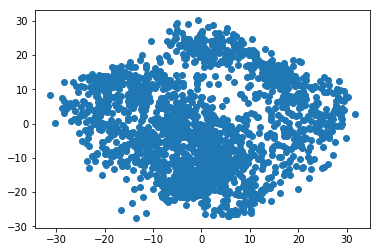

In [4]:
# PCA, représentation en 2D : 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1]);

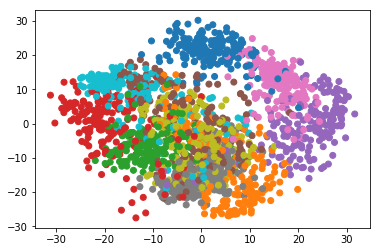

In [5]:
# Coloration des échantillons : 
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=["C"+str(i) for i in y]);

Clustering en cours... Terminé.
Affichage en cours...


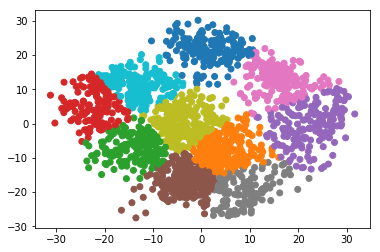

In [6]:
# K-Means clustering :
from sklearn.cluster import KMeans


def cluster(X, y):
    """ Effectue un clustering sur X avec k clusters, 
    où k est le nombre de classes trouvées dans y
    :return: y_pred : les prédictions des labels pour chaque point, en essayant de respecter
        la classification donnée par y
    """
    y_pred = KMeans(n_clusters=10).fit_predict(X)
    
    # On remet les vrais 'labels' pour avoir les mêmes couleurs que ci-dessus
    y_new = np.zeros_like(y_pred)
    deja_vu = [] # Pour éviter d'avoir plusieurs fois le même label
    for i in np.unique(y_pred):
        # On compte les occurences
        occu = np.unique(y[y_pred == i], return_counts=True)
        for label in deja_vu:
            idxs = np.where(occu[0] == label)[0]
            if len(idxs) > 0:
                idx = idxs[0]
                occu = (np.delete(occu[0], idx), np.delete(occu[1], idx))
        # On prend le label le plus présent : 
        lab = occu[0][np.argmax(occu[1])]
        deja_vu.append(lab)
        y_new[y_pred == i] = lab

    return y_new

print("Clustering en cours... ", end='')
y_new = cluster(X_reduced, y)
print("Terminé.")

# Affichage des résultats : 
plt.figure()
print("Affichage en cours...")
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=["C"+str(i) for i in y_new]);

In [7]:
# Comparaison des scores avec/sans PCA : 
from sklearn.metrics import accuracy_score

score_pca = accuracy_score(y_new, y)
score_full = accuracy_score(cluster(X, y), y)

print("Score sans PCA : %.2f%% d'échantillons correctement classés" % (score_full*100))
print("Score avec PCA : %.2f%% d'échantillons correctement classés" % (score_pca*100))

Score sans PCA : 76.13% d'échantillons correctement classés
Score avec PCA : 51.70% d'échantillons correctement classés


## Extraction de caractéristiques faciales

On envisage ici l'utilisation des techniques de décomposition par PCA et NMF pour l'extraction de caractéristiques utiles à la reconnaissance automatique de visages.

 - Étudier et tester le script ci-dessous. 

 - Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA. 


In [8]:
from time import time
from numpy.random import RandomState

from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition

On commence par préparer les données et définir quelques fonctions utilitaires :

Le dataset contient 400 visages


/home/loic/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:3316: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


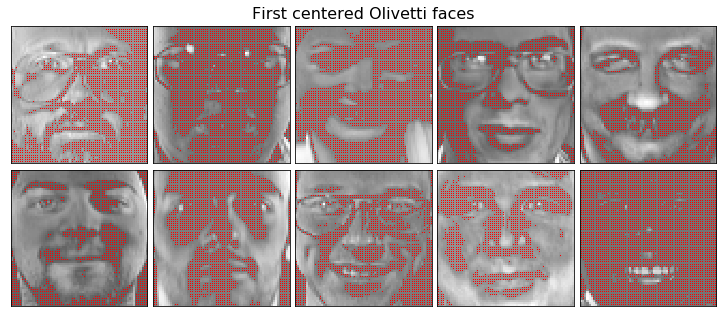

In [9]:
# -- Prepare data and define utility functions 

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(data_home='./tmp',shuffle=True,
                               random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print("Le dataset contient %d visages" % n_samples)

def plot_gallery(title, images):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)

        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0])>0:
            plt.plot( xz, yz, 'r,', hold=True)
#             print(len(dmy[0]), "negative-valued pixels") 

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Affichage de quelques données :
plot_gallery("First centered Olivetti faces",
             faces_centered[:n_components])


### A faire 

Modifier le script pour réaliser une évaluation des performances d'un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA ou la régression logistique our la classification. On effectuera l'évaluation par validation croisée. On observera l'évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# -- Transform

labels = dataset.target
X = faces
X_ = faces_centered

def get_accuracy(n_features, plot=False, verbose=False):
    """ Renvoie la précision en ne conservant que certaines features
    :param n_features: le nombre de features à conserver
    :return: le pourcentage de bonnes classifications """
    estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_features),
     True),

    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_features),
     False)
    ]
    scores = {elt[0]:0 for elt in estimators}
    
    for shortname, name, estimator, center in estimators:
        if verbose:
            print("Extracting the top %d %s... " % (n_features, name), end='')
            t0 = time()

        data = X
        if center:
            data = X_

        data = estimator.fit_transform(data)
        clf = LogisticRegression().fit(data,labels)
        acc = np.mean(cross_val_score(clf,data,labels,cv=5))
        scores[shortname] = acc
        if verbose:
            train_time = (time() - t0)
            print("done in %0.3fs" % train_time)
            print("\t -> Accuracy of ",shortname, ":", acc)
        if plot:
            components_ = estimator.components_
            plot_gallery('%s' % (name, train_time),
                         components_[:n_components])
    return scores
        
print("Comparaison : ")
print("Nombre de features | Score PCA (%) | Score NMF (%)")
for n in np.arange(5, 51, 5):
    scores = get_accuracy(n)
    print("%10d         | %10.2f    | %10.2f" % (n, scores["pca"]*100, scores["nmf"]*100))

Comparaison : 
Nombre de features | Score PCA (%) | Score NMF (%)
         5         |      49.50    |      34.25
        10         |      80.50    |      63.50
        15         |      90.25    |      75.00
        20         |      93.75    |      84.00
        25         |      94.25    |      86.00
        30         |      95.25    |      87.75
        35         |      96.25    |      86.75
        40         |      96.50    |      88.25
        45         |      97.00    |      87.75
        50         |      97.25    |      87.75


## Extraction de thèmes à partir de textes

Il s'agit dans cette partie de tester l'utilisation de la NMF pour l'extraction de thèmes à partir d'un corpus de textes ; l'idée principale étant d'interpréter chaque composante NMF extraite comme étant associée à un thème.

Étudier et tester le script suivant :

In [11]:
from sklearn.feature_extraction import text

On commence par définir quelques paramètres d'expérience : 

In [12]:
n_samples = 1000
n_features = 900
n_topics = 4
n_top_words = 20

 On charge les textes de certaines catégories du corpus [20newsgroups](http://qwone.com/~jason/20Newsgroups/) :

In [13]:
from sklearn import datasets
# Load the 20 newsgroups dataset 

t0 = time()

# Load some categories from the training set
categories = ['rec.sport.baseball','comp.graphics', 'comp.sys.mac.hardware',
              'talk.religion.misc']

print("Chargement des données...")
dataset = datasets.fetch_20newsgroups(data_home='tmp/text', shuffle=True,
                                      categories=categories, random_state=1)

print("Terminé en %0.3fs." % (time() - t0))

Chargement des données...
Terminé en 0.223s.


On représente chaque document par sa [TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) : 

In [14]:
# vectorize data using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

print("Extraction de la matrice TF-IDF...")
t0 = time()
vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features, stop_words='english')
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print("Terminé en %0.3fs." % (time() - t0))

Extraction de la matrice TF-IDF...
Terminé en 0.183s.


On applique la NMF :

In [15]:
# Fit the NMF model
print("Adaptation du modèle NMF avec n_samples=%d et n_features=%d..." %
    (n_samples, n_features))

t0 = time()
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf)
print("Terminé en %0.3fs." % (time() - t0))

# Decreasing the number of features
tfidf_nmf = nmf.transform(tfidf)


Adaptation du modèle NMF avec n_samples=1000 et n_features=900...
Terminé en 0.159s.


Et on interprète les "vecteurs de base" comme des thèmes :

In [16]:
# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #0:
edu year article team baseball cs players writes game university runs host nntp posting jewish good hit season games win
Topic #1:
graphics files file uk thanks ac 3d program package help ca image windows university computer need format posting use com
Topic #2:
com god jesus sandvik people christian writes bible don kent christians brian netcom koresh article life said newton just apple
Topic #3:
mac apple edu drive scsi quadra monitor problem video centris duo se problems card power drives software internal disk ram


La NMF permet donc de réaliser du clustering "doux" de documents : chaque document peut être associé à plusieurs thèmes à la fois.

## A faire

Reproduire l'expérience précédente en utilisant des GMM et en interprétant les thèmes à partir des centroïdes de chaque cluster.
 - Comparer le résultat obtenu au résultat NMF.
 - En interprétant les thèmes au travers des mots clés les plus représentatifs, repérer les thèmes pour lesquels les deux méthodes (NMF et GMM) semblent réaliser un consensus.
 - En étiquettant chaque document par les 3 thèmes les plus pertinents, avec les deux approches, proposer une méthode qui permette de caractériser le "taux d'accord" de ces deux approches quant à l'étiquetage des documents. Calculer ce "taux d'accord".

In [18]:
# Calcul de la précision avec NMF : 
clf = LogisticRegression().fit(tfidf_nmf,dataset.target[:n_samples])
acc = np.mean(cross_val_score(clf,tfidf_nmf,dataset.target[:n_samples],cv=5))
print("Précision avec NMF : %.2f%%" % (acc*100))

# Calcul de la précision avec les GMM :
from sklearn.mixture  import GaussianMixture
clf = GaussianMixture(n_components=4)
tfidf_array = tfidf.toarray()
clf.fit(tfidf_array)
y_pred = clf.predict(tfidf_array)
print(y_pred[:30])
y = dataset.target[:n_samples]
    
# On remet les vrais 'labels' pour avoir les mêmes couleurs que ci-dessus
y_new = np.zeros_like(y_pred)
deja_vu = [] # Pour éviter d'avoir plusieurs fois le même label
for i in np.unique(y_pred):
    # On compte les occurences
    occu = np.unique(y[y_pred == i], return_counts=True)
    for label in deja_vu:
        idxs = np.where(occu[0] == label)[0]
        if len(idxs) > 0:
            idx = idxs[0]
            occu = (np.delete(occu[0], idx), np.delete(occu[1], idx))
    # On prend le label le plus présent : 
#     print("occu:", occu)
    lab = occu[0][np.argmax(occu[1])]
    deja_vu.append(lab)
    y_new[y_pred == i] = lab


print(dataset.target[:30])
print(y_new[:30])
print("Précision avec GMM : %.2f%%" % accuracy_score(y, y_new))

Précision avec NMF : 82.42%
[0 2 3 1 3 1 2 0 0 0 2 0 2 2 0 2 3 1 2 1 0 1 2 0 0 3 3 1 2 2]
[0 1 2 3 2 2 1 0 1 0 0 0 2 1 0 1 2 3 2 0 0 3 1 0 0 2 2 3 1 1]
[0 1 2 3 2 3 1 0 0 0 1 0 1 1 0 1 2 3 1 3 0 3 1 0 0 2 2 3 1 1]
Précision avec GMM : 0.72%


In [22]:
# Comparaison des thèmes prédits : 
clf = LogisticRegression().fit(tfidf_nmf,dataset.target[:n_samples])
pred_nmf = clf.predict(tfidf_nmf)
clf = GaussianMixture(n_components=4).fit(tfidf_array)
pred_gmm = clf.predict(tfidf_array)


In [21]:
accords = y[pred_nmf == pred_gmm]
print(accords)
print(np.unique(accords, return_counts=True))

[0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 2 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 1 2 0 0 0 0 0 0 2 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 1 0 0 0 0 0 0 0 1 0 0 0 0 3 0 2 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 1 0 0 0 0 0]
(array([0, 1, 2, 3]), array([145,  13,  10,   3]))
